In [ ]:
%pip install numpy==1.26.4


In [ ]:
%pip install photutils==1.9.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for photutils: filename=photutils-1.9.0-cp312-cp312-linux_x86_64.whl size=1026027 sha256=cd4c332634976572e117a0979d98be01959cefb8c2a092c3181f59aacd08a35c
  Stored in directory: /root/.cache/pip/wheels/d3/8b/2a/3597f65e910d31a16f76d4f0ecbaa016c8316a48ef5a584f16
Successfully built photutils


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry

In [ ]:
from google.colab import files
files.upload()

Saving wh_0_set3.FIT to wh_0_set3.FIT
Saving wh_45_set3.FIT to wh_45_set3.FIT
Saving wh_90_set3.FIT to wh_90_set3.FIT


{'wh_0_set3.FIT': b"SIMPLE  =                    T /                                                BITPIX  =                   16 /                                                NAXIS   =                    2 /                                                NAXIS1  =                  512 /                                                NAXIS2  =                  512 /                                                OBJECT  = '        '           /                                                TELESCOP= 'Unknown Telescope'                                                   INSTRUME= 'SBIG ST-9'                                                           OBSERVER= 'Observer's Name'                                                     DATE-OBS= '2026-02-10T11:08:46.000' / GMT START OF EXPOSURE [WIN]               BZERO   = +3.276800000000E+004 /                                                BSCALE  = +1.000000000000E+000 /                                                EXPTIME = +1.2000000

In [ ]:
data = {
    '0':  '/content/wh_0_set3.FIT',
    '45':  '/content/wh_45_set3.FIT',
    '90': '/content/wh_90_set3.FIT',}

In [ ]:
images = {k: fits.getdata(v, ignore_missing_simple=True) for k, v in data.items()}

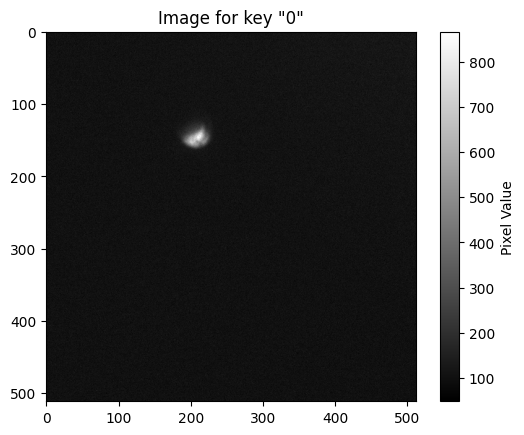

In [ ]:
plt.imshow(images['0'], cmap='gray')


plt.title('Image for key "0"')
plt.colorbar(label='Pixel Value')
plt.show()

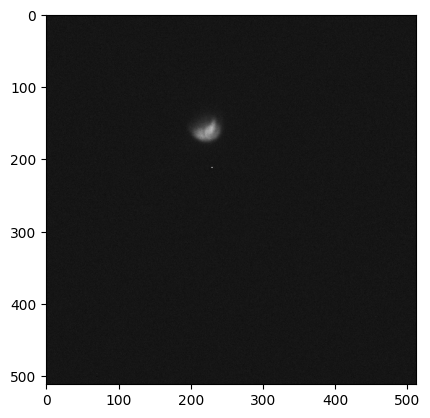

In [ ]:
plt.imshow(images['45'], cmap='gray')
plt.show()

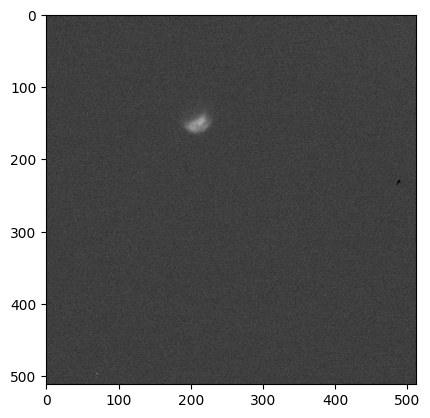

In [ ]:
plt.imshow(images['90'], cmap='gray')
plt.show()

center x, y =  [209.22295672] [147.29588532]


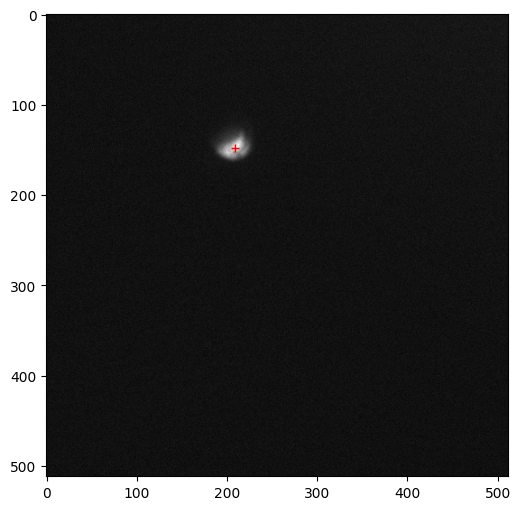

In [ ]:
x0, y0 = 200, 145 # rough guess for central coordinates of a star
cutout = 31 # subimage or cutout around x0, y0.

from photutils.centroids import centroid_2dg, centroid_sources

# centroid_2g will fit 2d gausssian arund x0,y0 to find exact cenetr

x, y = centroid_sources(images['0'], x0, y0, box_size=cutout, centroid_func=centroid_2dg)

print('center x, y = ',x,y)

plt.figure(figsize=(6,6))
plt.imshow(images['0'], cmap='gray')
plt.plot(x,y, 'r+')
plt.show()

In [ ]:
image = images['0']

In [ ]:
cutout_size = cutout # Already defined as 31 from previous step
half_cutout = int(cutout_size / 2)

x_center = int(x)
y_center = int(y)

# Calculate min and max coordinates for the cutout, ensuring they stay within image bounds
x_min = max(0, x_center - half_cutout)
x_max = min(image.shape[1], x_center + half_cutout + 1) # +1 because slicing is exclusive
y_min = max(0, y_center - half_cutout)
y_max = min(image.shape[0], y_center + half_cutout + 1) # +1 because slicing is exclusive

star_cutout = image[y_min:y_max, x_min:x_max]

print(f"Star cutout shape: {star_cutout.shape}")
print(f"Cutout x_min: {x_min}, x_max: {x_max}, y_min: {y_min}, y_max: {y_max}")


Star cutout shape: (31, 31)
Cutout x_min: 194, x_max: 225, y_min: 132, y_max: 163


/tmp/ipython-input-2146860284.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_center = int(x)
/tmp/ipython-input-2146860284.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_center = int(y)


In [ ]:
ny, nx = star_cutout.shape # Get dimensions of the star_cutout

x_indices = np.arange(nx) # Create 1D array for x-coordinates
y_indices = np.arange(ny) # Create 1D array for y-coordinates

x_mesh, y_mesh = np.meshgrid(x_indices, y_indices) # Create 2D coordinate grids

x_data = x_mesh.ravel() # Flatten x_mesh into 1D array
y_data = y_mesh.ravel() # Flatten y_mesh into 1D array
z_data = star_cutout.ravel() # Flatten star_cutout into 1D array

print(f"Shape of x_mesh: {x_mesh.shape}")
print(f"Shape of y_mesh: {y_mesh.shape}")
print(f"Shape of z_data (flattened cutout): {z_data.shape}")

Shape of x_mesh: (31, 31)
Shape of y_mesh: (31, 31)
Shape of z_data (flattened cutout): (961,)


In [ ]:
from astropy.modeling.models import Gaussian2D
from astropy.modeling.fitting import LevMarLSQFitter

# Initial guesses for Gaussian parameters
amplitude_guess = np.max(star_cutout) # Use the maximum pixel value as initial amplitude
x_mean_guess = nx / 2.0 # Center of the cutout in x
y_mean_guess = ny / 2.0 # Center of the cutout in y
x_stddev_guess = 2.0 # Initial guess for standard deviation in x
y_stddev_guess = 2.0 # Initial guess for standard deviation in y

# Define the 2D Gaussian model with initial guesses
g_init = Gaussian2D(amplitude=amplitude_guess, x_mean=x_mean_guess, y_mean=y_mean_guess,
                     x_stddev=x_stddev_guess, y_stddev=y_stddev_guess)

print(f"Initial Gaussian parameters: ")
print(f"  Amplitude: {g_init.amplitude.value}")
print(f"  x_mean: {g_init.x_mean.value}")
print(f"  y_mean: {g_init.y_mean.value}")
print(f"  x_stddev: {g_init.x_stddev.value}")
print(f"  y_stddev: {g_init.y_stddev.value}")

Initial Gaussian parameters: 
  Amplitude: 867.0
  x_mean: 15.5
  y_mean: 15.5
  x_stddev: 2.0
  y_stddev: 2.0


In [ ]:
fitter = LevMarLSQFitter() # Initialize the fitter
g_fit = fitter(g_init, x_data, y_data, z_data) # Fit the model to the data

print(f"Fitted Gaussian parameters:")
print(f"  Amplitude: {g_fit.amplitude.value:.2f}")
print(f"  x_mean: {g_fit.x_mean.value:.2f}")
print(f"  y_mean: {g_fit.y_mean.value:.2f}")
print(f"  x_stddev: {g_fit.x_stddev.value:.2f}")
print(f"  y_stddev: {g_fit.y_stddev.value:.2f}")

Fitted Gaussian parameters:
  Amplitude: 754.20
  x_mean: 14.27
  y_mean: 15.77
  x_stddev: 13.21
  y_stddev: 8.97


In [ ]:
fwhm_x = 2 * np.sqrt(2 * np.log(2)) * g_fit.x_stddev.value
fwhm_y = 2 * np.sqrt(2 * np.log(2)) * g_fit.y_stddev.value

print(f"FWHM in x-direction: {fwhm_x:.2f}")
print(f"FWHM in y-direction: {fwhm_y:.2f}")

FWHM in x-direction: 31.10
FWHM in y-direction: 21.12


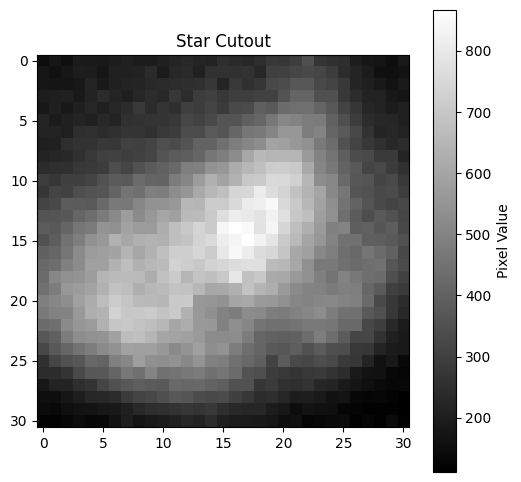

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(star_cutout, cmap='gray')
plt.title('Star Cutout')
plt.colorbar(label='Pixel Value')
plt.show()

In [ ]:
fwhm_avg = np.mean([fwhm_x, fwhm_y])

print(f"Average FWHM: {fwhm_avg:.2f}")

Average FWHM: 26.11


In [ ]:
aperture_radius = 1.5 * fwhm_avg
print(f"Aperture radius: {aperture_radius:.2f}")

Aperture radius: 39.16


In [ ]:
fitted_x_image = x_min + g_fit.x_mean.value
fitted_y_image = y_min + g_fit.y_mean.value

positions = [(fitted_x_image, fitted_y_image)]

# Define background annulus radii
inner_annulus_radius = 2.0 * aperture_radius
outer_annulus_radius = 3.0 * aperture_radius

# Create aperture and annulus objects
aperture = CircularAperture(positions, r=aperture_radius)
annulus_aperture = CircularAnnulus(positions, r_in=inner_annulus_radius, r_out=outer_annulus_radius)

print(f"Fitted star center in original image: x={fitted_x_image:.2f}, y={fitted_y_image:.2f}")
print(f"Aperture radius: {aperture_radius:.2f}")
print(f"Inner annulus radius: {inner_annulus_radius:.2f}")
print(f"Outer annulus radius: {outer_annulus_radius:.2f}")

Fitted star center in original image: x=208.27, y=147.77
Aperture radius: 39.16
Inner annulus radius: 78.32
Outer annulus radius: 117.48


In [ ]:
phot_table = aperture_photometry(image, aperture)
annulus_phot_table = aperture_photometry(image, annulus_aperture)

# Calculate mean background in the annulus
b_mean = annulus_phot_table['aperture_sum'] / annulus_aperture.area

# Calculate total background in the aperture
b_sum = b_mean * aperture.area

# Calculate background-subtracted flux
final_flux0 = phot_table['aperture_sum'] - b_sum

print(f"Raw aperture flux: {phot_table['aperture_sum'][0]:.2f}")
print(f"Mean background per pixel: {b_mean[0]:.2f}")
print(f"Total background in aperture: {b_sum[0]:.2f}")
print(f"Background-subtracted flux: {final_flux0[0]:.2f}")

Raw aperture flux: 877436.76
Mean background per pixel: 107.27
Total background in aperture: 516824.62
Background-subtracted flux: 360612.14


Code 2

center x, y =  [222.95816358] [164.2635879]


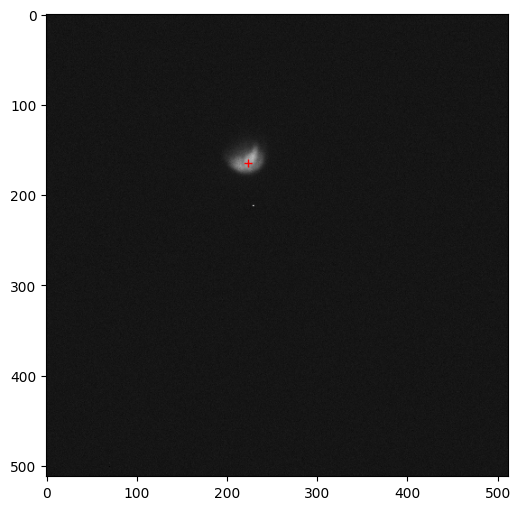

In [ ]:
x0, y0 = 210, 170 # rough guess for central coordinates of a star
cutout = 31 # subimage or cutout around x0, y0.

from photutils.centroids import centroid_2dg, centroid_sources

# centroid_2g will fit 2d gausssian arund x0,y0 to find exact cenetr

x, y = centroid_sources(images['45'], x0, y0, box_size=cutout, centroid_func=centroid_2dg)

print('center x, y = ',x,y)

plt.figure(figsize=(6,6))
plt.imshow(images['45'], cmap='gray')
plt.plot(x,y, 'r+')
plt.show()

In [ ]:
image = images['45']

In [ ]:
cutout_size = cutout # Already defined as 31 from previous step
half_cutout = int(cutout_size / 2)

x_center = int(x)
y_center = int(y)

# Calculate min and max coordinates for the cutout, ensuring they stay within image bounds
x_min = max(0, x_center - half_cutout)
x_max = min(image.shape[1], x_center + half_cutout + 1) # +1 because slicing is exclusive
y_min = max(0, y_center - half_cutout)
y_max = min(image.shape[0], y_center + half_cutout + 1) # +1 because slicing is exclusive

star_cutout = image[y_min:y_max, x_min:x_max]

print(f"Star cutout shape: {star_cutout.shape}")
print(f"Cutout x_min: {x_min}, x_max: {x_max}, y_min: {y_min}, y_max: {y_max}")


Star cutout shape: (31, 31)
Cutout x_min: 207, x_max: 238, y_min: 149, y_max: 180


/tmp/ipython-input-2146860284.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_center = int(x)
/tmp/ipython-input-2146860284.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_center = int(y)


In [ ]:
ny, nx = star_cutout.shape # Get dimensions of the star_cutout

x_indices = np.arange(nx) # Create 1D array for x-coordinates
y_indices = np.arange(ny) # Create 1D array for y-coordinates

x_mesh, y_mesh = np.meshgrid(x_indices, y_indices) # Create 2D coordinate grids

x_data = x_mesh.ravel() # Flatten x_mesh into 1D array
y_data = y_mesh.ravel() # Flatten y_mesh into 1D array
z_data = star_cutout.ravel() # Flatten star_cutout into 1D array

print(f"Shape of x_mesh: {x_mesh.shape}")
print(f"Shape of y_mesh: {y_mesh.shape}")
print(f"Shape of z_data (flattened cutout): {z_data.shape}")

Shape of x_mesh: (31, 31)
Shape of y_mesh: (31, 31)
Shape of z_data (flattened cutout): (961,)


In [ ]:
from astropy.modeling.models import Gaussian2D
from astropy.modeling.fitting import LevMarLSQFitter

# Initial guesses for Gaussian parameters
amplitude_guess = np.max(star_cutout) # Use the maximum pixel value as initial amplitude
x_mean_guess = nx / 2.0 # Center of the cutout in x
y_mean_guess = ny / 2.0 # Center of the cutout in y
x_stddev_guess = 2.0 # Initial guess for standard deviation in x
y_stddev_guess = 2.0 # Initial guess for standard deviation in y

# Define the 2D Gaussian model with initial guesses
g_init = Gaussian2D(amplitude=amplitude_guess, x_mean=x_mean_guess, y_mean=y_mean_guess,
                     x_stddev=x_stddev_guess, y_stddev=y_stddev_guess)

print(f"Initial Gaussian parameters: ")
print(f"  Amplitude: {g_init.amplitude.value}")
print(f"  x_mean: {g_init.x_mean.value}")
print(f"  y_mean: {g_init.y_mean.value}")
print(f"  x_stddev: {g_init.x_stddev.value}")
print(f"  y_stddev: {g_init.y_stddev.value}")

Initial Gaussian parameters: 
  Amplitude: 869.0
  x_mean: 15.5
  y_mean: 15.5
  x_stddev: 2.0
  y_stddev: 2.0


In [ ]:
fitter = LevMarLSQFitter() # Initialize the fitter
g_fit = fitter(g_init, x_data, y_data, z_data) # Fit the model to the data

print(f"Fitted Gaussian parameters:")
print(f"  Amplitude: {g_fit.amplitude.value:.2f}")
print(f"  x_mean: {g_fit.x_mean.value:.2f}")
print(f"  y_mean: {g_fit.y_mean.value:.2f}")
print(f"  x_stddev: {g_fit.x_stddev.value:.2f}")
print(f"  y_stddev: {g_fit.y_stddev.value:.2f}")

Fitted Gaussian parameters:
  Amplitude: 777.88
  x_mean: 16.66
  y_mean: 13.40
  x_stddev: 14.62
  y_stddev: 9.22


In [ ]:
fwhm_x = 2 * np.sqrt(2 * np.log(2)) * g_fit.x_stddev.value
fwhm_y = 2 * np.sqrt(2 * np.log(2)) * g_fit.y_stddev.value

print(f"FWHM in x-direction: {fwhm_x:.2f}")
print(f"FWHM in y-direction: {fwhm_y:.2f}")

FWHM in x-direction: 34.42
FWHM in y-direction: 21.71


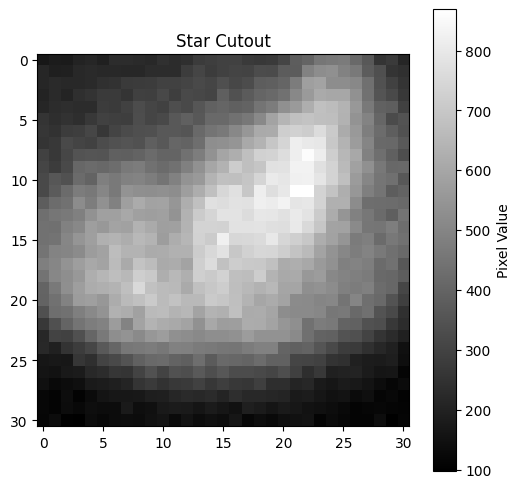

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(star_cutout, cmap='gray')
plt.title('Star Cutout')
plt.colorbar(label='Pixel Value')
plt.show()

In [ ]:
fwhm_avg = np.mean([fwhm_x, fwhm_y])

print(f"Average FWHM: {fwhm_avg:.2f}")

Average FWHM: 28.07


In [ ]:
aperture_radius = 1.5 * fwhm_avg
print(f"Aperture radius: {aperture_radius:.2f}")

Aperture radius: 42.10


In [ ]:
fitted_x_image = x_min + g_fit.x_mean.value
fitted_y_image = y_min + g_fit.y_mean.value

positions = [(fitted_x_image, fitted_y_image)]

# Define background annulus radii
inner_annulus_radius = 2.0 * aperture_radius
outer_annulus_radius = 3.0 * aperture_radius

# Create aperture and annulus objects
aperture = CircularAperture(positions, r=aperture_radius)
annulus_aperture = CircularAnnulus(positions, r_in=inner_annulus_radius, r_out=outer_annulus_radius)

print(f"Fitted star center in original image: x={fitted_x_image:.2f}, y={fitted_y_image:.2f}")
print(f"Aperture radius: {aperture_radius:.2f}")
print(f"Inner annulus radius: {inner_annulus_radius:.2f}")
print(f"Outer annulus radius: {outer_annulus_radius:.2f}")

Fitted star center in original image: x=223.66, y=162.40
Aperture radius: 42.10
Inner annulus radius: 84.20
Outer annulus radius: 126.29


In [ ]:
phot_table = aperture_photometry(image, aperture)
annulus_phot_table = aperture_photometry(image, annulus_aperture)

# Calculate mean background in the annulus
b_mean = annulus_phot_table['aperture_sum'] / annulus_aperture.area

# Calculate total background in the aperture
b_sum = b_mean * aperture.area

# Calculate background-subtracted flux
final_flux1 = phot_table['aperture_sum'] - b_sum

print(f"Raw aperture flux: {phot_table['aperture_sum'][0]:.2f}")
print(f"Mean background per pixel: {b_mean[0]:.2f}")
print(f"Total background in aperture: {b_sum[0]:.2f}")
print(f"Background-subtracted flux: {final_flux1[0]:.2f}")

Raw aperture flux: 1003708.49
Mean background per pixel: 102.51
Total background in aperture: 570750.84
Background-subtracted flux: 432957.66


Code 3

center x, y =  [210.1793314] [151.69211822]


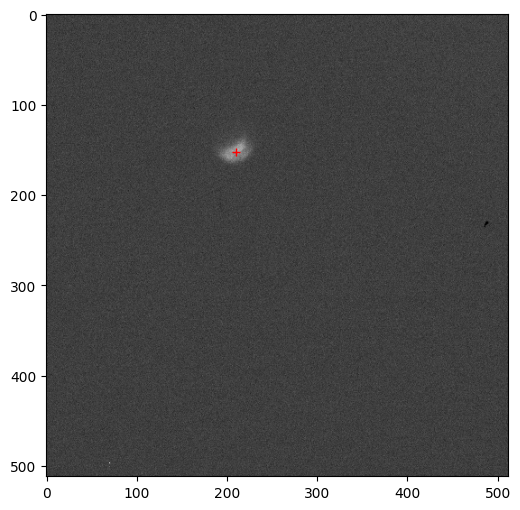

In [ ]:
x0, y0 = 200, 150 # rough guess for central coordinates of a star
cutout = 31 # subimage or cutout around x0, y0.

from photutils.centroids import centroid_2dg, centroid_sources

# centroid_2g will fit 2d gausssian arund x0,y0 to find exact cenetr

x, y = centroid_sources(images['90'], x0, y0, box_size=cutout, centroid_func=centroid_2dg)

print('center x, y = ',x,y)

plt.figure(figsize=(6,6))
plt.imshow(images['90'], cmap='gray')
plt.plot(x,y, 'r+')
plt.show()

In [ ]:
image = images['90']

In [ ]:
cutout_size = cutout # Already defined as 31 from previous step
half_cutout = int(cutout_size / 2)

x_center = int(x)
y_center = int(y)

# Calculate min and max coordinates for the cutout, ensuring they stay within image bounds
x_min = max(0, x_center - half_cutout)
x_max = min(image.shape[1], x_center + half_cutout + 1) # +1 because slicing is exclusive
y_min = max(0, y_center - half_cutout)
y_max = min(image.shape[0], y_center + half_cutout + 1) # +1 because slicing is exclusive

star_cutout = image[y_min:y_max, x_min:x_max]

print(f"Star cutout shape: {star_cutout.shape}")
print(f"Cutout x_min: {x_min}, x_max: {x_max}, y_min: {y_min}, y_max: {y_max}")


Star cutout shape: (31, 31)
Cutout x_min: 195, x_max: 226, y_min: 136, y_max: 167


/tmp/ipython-input-2146860284.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_center = int(x)
/tmp/ipython-input-2146860284.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_center = int(y)


In [ ]:
ny, nx = star_cutout.shape # Get dimensions of the star_cutout

x_indices = np.arange(nx) # Create 1D array for x-coordinates
y_indices = np.arange(ny) # Create 1D array for y-coordinates

x_mesh, y_mesh = np.meshgrid(x_indices, y_indices) # Create 2D coordinate grids

x_data = x_mesh.ravel() # Flatten x_mesh into 1D array
y_data = y_mesh.ravel() # Flatten y_mesh into 1D array
z_data = star_cutout.ravel() # Flatten star_cutout into 1D array

print(f"Shape of x_mesh: {x_mesh.shape}")
print(f"Shape of y_mesh: {y_mesh.shape}")
print(f"Shape of z_data (flattened cutout): {z_data.shape}")

Shape of x_mesh: (31, 31)
Shape of y_mesh: (31, 31)
Shape of z_data (flattened cutout): (961,)


In [ ]:
from astropy.modeling.models import Gaussian2D
from astropy.modeling.fitting import LevMarLSQFitter

# Initial guesses for Gaussian parameters
amplitude_guess = np.max(star_cutout) # Use the maximum pixel value as initial amplitude
x_mean_guess = nx / 2.0 # Center of the cutout in x
y_mean_guess = ny / 2.0 # Center of the cutout in y
x_stddev_guess = 2.0 # Initial guess for standard deviation in x
y_stddev_guess = 2.0 # Initial guess for standard deviation in y

# Define the 2D Gaussian model with initial guesses
g_init = Gaussian2D(amplitude=amplitude_guess, x_mean=x_mean_guess, y_mean=y_mean_guess,
                     x_stddev=x_stddev_guess, y_stddev=y_stddev_guess)

print(f"Initial Gaussian parameters: ")
print(f"  Amplitude: {g_init.amplitude.value}")
print(f"  x_mean: {g_init.x_mean.value}")
print(f"  y_mean: {g_init.y_mean.value}")
print(f"  x_stddev: {g_init.x_stddev.value}")
print(f"  y_stddev: {g_init.y_stddev.value}")

Initial Gaussian parameters: 
  Amplitude: 299.0
  x_mean: 15.5
  y_mean: 15.5
  x_stddev: 2.0
  y_stddev: 2.0


In [ ]:
fitter = LevMarLSQFitter() # Initialize the fitter
g_fit = fitter(g_init, x_data, y_data, z_data) # Fit the model to the data

print(f"Fitted Gaussian parameters:")
print(f"  Amplitude: {g_fit.amplitude.value:.2f}")
print(f"  x_mean: {g_fit.x_mean.value:.2f}")
print(f"  y_mean: {g_fit.y_mean.value:.2f}")
print(f"  x_stddev: {g_fit.x_stddev.value:.2f}")
print(f"  y_stddev: {g_fit.y_stddev.value:.2f}")

Fitted Gaussian parameters:
  Amplitude: 248.09
  x_mean: 15.02
  y_mean: 15.67
  x_stddev: 18.14
  y_stddev: 12.13


In [ ]:
fwhm_x = 2 * np.sqrt(2 * np.log(2)) * g_fit.x_stddev.value
fwhm_y = 2 * np.sqrt(2 * np.log(2)) * g_fit.y_stddev.value

print(f"FWHM in x-direction: {fwhm_x:.2f}")
print(f"FWHM in y-direction: {fwhm_y:.2f}")

FWHM in x-direction: 42.71
FWHM in y-direction: 28.56


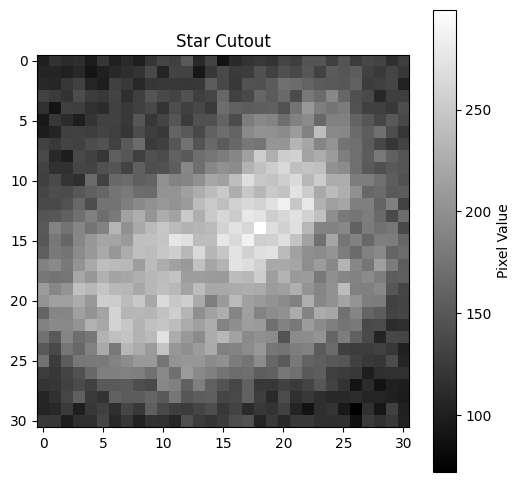

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(star_cutout, cmap='gray')
plt.title('Star Cutout')
plt.colorbar(label='Pixel Value')
plt.show()

In [ ]:
fwhm_avg = np.mean([fwhm_x, fwhm_y])

print(f"Average FWHM: {fwhm_avg:.2f}")

Average FWHM: 35.63


In [ ]:
aperture_radius = 1.5 * fwhm_avg
print(f"Aperture radius: {aperture_radius:.2f}")

Aperture radius: 53.45


In [ ]:
fitted_x_image = x_min + g_fit.x_mean.value
fitted_y_image = y_min + g_fit.y_mean.value

positions = [(fitted_x_image, fitted_y_image)]

# Define background annulus radii
inner_annulus_radius = 2.0 * aperture_radius
outer_annulus_radius = 3.0 * aperture_radius

# Create aperture and annulus objects
aperture = CircularAperture(positions, r=aperture_radius)
annulus_aperture = CircularAnnulus(positions, r_in=inner_annulus_radius, r_out=outer_annulus_radius)

print(f"Fitted star center in original image: x={fitted_x_image:.2f}, y={fitted_y_image:.2f}")
print(f"Aperture radius: {aperture_radius:.2f}")
print(f"Inner annulus radius: {inner_annulus_radius:.2f}")
print(f"Outer annulus radius: {outer_annulus_radius:.2f}")

Fitted star center in original image: x=210.02, y=151.67
Aperture radius: 53.45
Inner annulus radius: 106.90
Outer annulus radius: 160.36


In [ ]:
phot_table = aperture_photometry(image, aperture)
annulus_phot_table = aperture_photometry(image, annulus_aperture)

# Calculate mean background in the annulus
b_mean = annulus_phot_table['aperture_sum'] / annulus_aperture.area

# Calculate total background in the aperture
b_sum = b_mean * aperture.area

# Calculate background-subtracted flux
final_flux90 = phot_table['aperture_sum'] - b_sum

print(f"Raw aperture flux: {phot_table['aperture_sum'][0]:.2f}")
print(f"Mean background per pixel: {b_mean[0]:.2f}")
print(f"Total background in aperture: {b_sum[0]:.2f}")
print(f"Background-subtracted flux: {final_flux90[0]:.2f}")

Raw aperture flux: 1008436.78
Mean background per pixel: 101.34
Total background in aperture: 909646.36
Background-subtracted flux: 98790.42


In [ ]:
flux_0=final_flux0
flux_45=final_flux1
flux_90=final_flux90

# Task
Calculate Stokes parameters (I, Q, U), Degree of Linear Polarization (DoLP), and Angle of Polarization (AoP) using the extracted fluxes `flux_0`, `flux_45`, and `flux_90`. Display all calculated values.

## Calculate Stokes Parameters (I, Q, U)

### Subtask:
Compute the Stokes parameters I, Q, and U using the extracted fluxes `flux_0`, `flux_45`, and `flux_90` based on standard linear polarization formulas.


**Reasoning**:
The subtask requires calculating Stokes parameters I, Q, and U using the provided formulas and fluxes. I will implement these calculations in a code block.



In [ ]:
I = flux_0 + flux_90
Q = flux_0 - flux_90
U = 2 * flux_45 - (flux_0 + flux_90)

print(f"Stokes Parameter I: {I[0]:.2f}")
print(f"Stokes Parameter Q: {Q[0]:.2f}")
print(f"Stokes Parameter U: {U[0]:.2f}")

Stokes Parameter I: 459402.56
Stokes Parameter Q: 261821.72
Stokes Parameter U: 406512.76


**Reasoning**:
Now that the Stokes parameters I, Q, and U have been calculated, the next logical step is to compute the Degree of Linear Polarization (DoLP) and the Angle of Polarization (AoP) using these values. This will fulfill the remaining part of the overall task.



In [ ]:
DoLP = np.sqrt(Q**2 + U**2) / I
AoP = 0.5 * np.degrees(np.arctan2(U, Q))

print(f"Degree of Linear Polarization (DoLP): {DoLP[0]:.4f}")
print(f"Angle of Polarization (AoP): {AoP[0]:.2f} degrees")

Degree of Linear Polarization (DoLP): 1.0525
Angle of Polarization (AoP): 28.61 degrees
